# Project 4: Wrangle and Analyze Data

## Table of Contents
- [Introduction](#intro)
- [Gathering data](#gather)
- [Assessing data](#assess)
    - [Quality Issues](#quality_issues)
    - [Tidiness Issues](#tidiness_issues)
- [Cleaning data](#clean)
- [Storing data](#store)
    - [Storing data into a CSV file](#store_csv)
    - [Storing data into a SQLite database](#store_sql)
- [Analysing data](#analysis)

<a id='intro'></a>
## Introduction

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

Key points to keep in mind when data wrangling for this project:

- You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
- Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
- Cleaning includes merging individual pieces of data according to the rules of tidy data.
- The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
- You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

<a id='gather'></a>
## Gathering data

First of all I will load all the libraries that I will use in this report.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import requests
import tweepy
import json
import sqlite3
import seaborn as sns

%matplotlib inline

### Read WeRateDogs Twitter archive (CSV)

To read this file i will use pandas, because it's already loaded in the environment and it already in a CSV format.

In [2]:
# Read the data from the CSV
twitter_data = pd.read_csv('twitter-archive-enhanced.csv')

# Show the header
twitter_data.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### Read tweet image predictions (TSV)

In this case, first we need to import the data from the Udacity's servers and then read the file using the tab as a seperator.

In [3]:
# Import the data programmatically using 'requests'
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

# Save the data into a file called 'image_predictions.tsv'
with open ('image_predictions.tsv', 'wb') as file:
    file.write(r.content)

# Read the file using tab as a seperator
img_pred = pd.read_table('image_predictions.tsv', sep='\t')

# Show the header
img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Read from the Twitter API (JSON)

In this case first I need to have the API keys and then import the data using the [API of Twitter](https://developer.twitter.com/en).

In [4]:
### Configuration of the credentails for the Twitter API
consumer_key = 'CONSUMER KEY'
consumer_secret = 'CONSUMER SECRET'
access_token = 'ACCESS TOKEN'
access_secret = 'ACCESS SECRET'

# Get the authorization token from the API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Get the API access
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In this case, we already know the ID of each tweet that we want to have information in the dataframe called `twitter_data` in the column `tweet_id`.

In [5]:
# Create array for each tweet
api_tweets = []

# Create array with the correct and wrong ID's
correct_id = []
wrong_id = []

# Get the data for each tweet using the API
for tweet_id in twitter_data['tweet_id']:
    data = {}
    try: 
        info = api.get_status(tw_id, tweet_mode='extended', wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
        data['tweet_id'] = tweet_id
        data['retweet_count'] = info._json['retweet_count']
        data['favorite_count'] = info._json['favorite_count']
        
        # Add the tweet info in the array api_tweets
        api_tweets.append(data)
        
        # Add the id to the array of correct id's        
        correct_id.append(tweet_id)
        
    except Exception as e:
        # Add the id to the array of wrong id's        
        wrong_id.append(tweet_id)
        
# Transform the array to a pandas dataframe
api_data = pd.DataFrame(api_tweets)

Once I have dowloaded the data from the API of Twitter, I will save all this data into a CSV using the `utf-8` encoding.

In [6]:
# Save the API data to a CSV without the index
api_data.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

# Read the data from the txt file
api_data = pd.read_csv('tweet_json.txt')

# Show the header
api_data.head()

,favorite_count,retweet_count,tweet_id
0,38827,8595,892420643555336193
1,33260,6316,892177421306343426
2,25056,4192,891815181378084864
3,42206,8707,891689557279858688
4,40353,9480,891327558926688256


<a id='assess'></a>
## Assessing data

To assess the data, first I will do the assessment individually for each dataset and at the end I will merge them. The 3 dataframes I will be working on are:

- `twitter_data`: Info for each tweet data like the timestamp and the rating
- `img_pred`: Image predictions for each tweet
- `api_data`: Twitter API with the nº of retweets and favorite

### Assessing `twitter_data`

In [7]:
# Show the header of 'twitter_data'
twitter_data.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
# Show the info of 'twitter_data'
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
# Show the info of 'twitter_data'
twitter_data.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
# Check if there are duplicated and nulls tweets
sum(twitter_data.tweet_id.duplicated()), sum(twitter_data.tweet_id.isnull())

(0, 0)

In [11]:
# Table with the different names
twitter_data.name.value_counts().head(10)

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Penny       10
Lola        10
Tucker      10
Bo           9
Name: name, dtype: int64

In [12]:
# Number of retweeted tweets
sum((twitter_data.retweeted_status_id.isna()) == False)

181

In [13]:
# Count values for 'doggo'
twitter_data.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [14]:
# Count values for 'floofer'
twitter_data.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [15]:
# Count values for 'pupper'
twitter_data.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [16]:
# Count values for 'puppo'
twitter_data.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

### Assessing `img_pred`

In [17]:
# Show the header of 'img_pred'
img_pred.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [18]:
# Show the info of 'img_pred'
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
# Show the description of 'img_pred'
img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
# Check if there are duplicated and nulls tweets
sum(img_pred.tweet_id.duplicated()), sum(img_pred.tweet_id.isnull())

(0, 0)

### Assessing `api_data`

In [21]:
# Show the header of 'api_data'
api_data.head()

,favorite_count,retweet_count,tweet_id
0,38827,8595,892420643555336193
1,33260,6316,892177421306343426
2,25056,4192,891815181378084864
3,42206,8707,891689557279858688
4,40353,9480,891327558926688256


In [22]:
# Show the info of 'api_data'
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
favorite_count    2345 non-null int64
retweet_count     2345 non-null int64
tweet_id          2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [23]:
# Show the description of 'api_data'
api_data.describe()

,favorite_count,retweet_count,tweet_id
count,2345.000000,2345.000000,2.345000e+03
mean,8072.560341,3027.631983,7.422940e+17
std,12146.311778,5036.008926,6.833642e+16
min,0.000000,0.000000,6.660209e+17
25%,1404.000000,607.000000,6.783802e+17
50%,3541.000000,1414.000000,7.189392e+17
75%,9980.000000,3525.000000,7.986979e+17
max,143493.000000,77409.000000,8.924206e+17


In [24]:
# Check if there are duplicated and nulls tweets
sum(api_data.tweet_id.duplicated()), sum(api_data.tweet_id.isnull())

(0, 0)

<a id='quality_issues'></a>
### Quality Issues

1. [Q1 - Tweets without images](#q1)
    - In the dataframe `twitter_data` there are some tweets that they don't have images, so we don't have predicted data for them.

<br>

2. [Q2 - Wrong expanded urls](#q2)
    - In the dataframe `twitter_data` in some cases the url is wrong and also there in some cases there are multiple URL's.
    
<br>

3. [Q3 - Wrong names of dogs](#q3)
    - In the dataframe `twitter_data` in some cases the name of the dog is wrong (like "a", "an", "by", etc.) and also there are some that are missing or are defined like "None".

<br>

4. [Q4 - Remove retweets](#q4)
    - In the dataframe `twitter_data` there are some tweets that they are retweets from other tweets. We only want the original ratings.

<br>

5. [Q5 - Wrong breed of dogs](#q5)
    - In the dataframe `img_pred` some of the predictions are not a breed of a dog (like for example "shopping_cart").

<br>

6. [Q6 - Wrong data type for the timestamp](#q6)
    - In the dataframe `twitter_data` the column `timestamp` has the data type `object` and it should be `datetime64`.

<br>

7. [Q7 - Wrong data type for the tweet id](#q7)
    - In all 3 dataframes the `tweet_id` has the data type `int`, the id's should be a `string`.

<br>

8. [Q8 - Missing values](#q8)
    - In the dataframe `twitter_data` the columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` they have a lot of missing values.

<br>

<a id='tidiness_issues'></a>
### Tidiness Issues

1. [T1 - Multiple columns for the dogo stage](#t1)
    - In the dataframe `twitter_data` the dogo stage is splitted in 4 columns (doggo, floofer, pupper, puppo).

<br>

2. [T2 - Merge all the data](#t2)
    - Merge all 3 dataframes using the `tweet_id` column in a unique dataframe.

<a id='clean'></a>
## Cleaning data

In this part I will clean all the quality and tidiness issues.

But before doing any change, I will do a copy of the data.

In [25]:
# Create a copy of all the original dataframes
twitter_data_clean = twitter_data.copy()
img_pred_clean = img_pred.copy()
api_data_clean = api_data.copy()

Once we have done the copies, let's do the cleaning on the data.

<a id='q1'></a>
### Q1 - Tweets without images

#### Define

**Problem:** In the dataframe `twitter_data` there are some tweets that they don't have images, so we don't have predicted data for them.

**Solution:** Remove the tweets that we don't have image prediction for them. To do this I found help in this [page](https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql).

#### Code

In [26]:
# Check the number of rows in "twitter_data" before removing the tweets that we don't have prediction data
len(twitter_data_clean)

2356

In [27]:
# Create and array with the list of all the tweets that we have image prediciton
list_tweet_id = img_pred_clean.tweet_id

# Filter only the tweets that we have prediction data
twitter_data_clean.query('tweet_id in @list_tweet_id', inplace = True)

#### Test

In [28]:
# Check the number of rows in "twitter_data" after removing the tweets that we don't have prediction data
len(twitter_data_clean)

2075

<a id='q2'></a>
### Q2 - Wrong expanded urls

#### Define

**Problem:** In the dataframe `twitter_data` in some cases the url is wrong and also there in some cases there are multiple URL's.

**Solution:** We assume that the format of the URL is always the same and it only change the ID of each tweet. Using regex I will extract the correct url from all the tweets and copy this clean urls in a new column called `clean_urls`. To do this I found help in this [page](https://stackoverflow.com/questions/1327369/extract-part-of-a-regex-match).

#### Code

In [29]:
# Check the first 10 expanded_urls
twitter_data_clean.expanded_urls.head(10)

0    https://twitter.com/dog_rates/status/892420643...
1    https://twitter.com/dog_rates/status/892177421...
2    https://twitter.com/dog_rates/status/891815181...
3    https://twitter.com/dog_rates/status/891689557...
4    https://twitter.com/dog_rates/status/891327558...
5    https://twitter.com/dog_rates/status/891087950...
6    https://gofundme.com/ydvmve-surgery-for-jax,ht...
7    https://twitter.com/dog_rates/status/890729181...
8    https://twitter.com/dog_rates/status/890609185...
9    https://twitter.com/dog_rates/status/890240255...
Name: expanded_urls, dtype: object

In [30]:
# Extract url based with regex
twitter_data_clean['clean_urls'] = twitter_data_clean['expanded_urls'].str.\
                                   extract('(https://twitter.com/dog_rates/status/\d{1,18}/photo/1)', expand=True)

In [31]:
# Remove the column "expanded_urls"
twitter_data_clean.drop('expanded_urls', axis = 1, inplace = True)

#### Test

In [32]:
# Check the first 10 clean_urls
twitter_data_clean.clean_urls.head(10)

0    https://twitter.com/dog_rates/status/892420643...
1    https://twitter.com/dog_rates/status/892177421...
2    https://twitter.com/dog_rates/status/891815181...
3    https://twitter.com/dog_rates/status/891689557...
4    https://twitter.com/dog_rates/status/891327558...
5    https://twitter.com/dog_rates/status/891087950...
6    https://twitter.com/dog_rates/status/890971913...
7    https://twitter.com/dog_rates/status/890729181...
8    https://twitter.com/dog_rates/status/890609185...
9    https://twitter.com/dog_rates/status/890240255...
Name: clean_urls, dtype: object

<a id='q3'></a>
### Q3 - Wrong names of dogs

#### Define

**Problem:** In the dataframe `twitter_data` in some cases the name of the dog is wrong (like "a", "an", "by", etc.) and also there are some that are missing or are defined like "None".

**Solution:** In this case I will assume that all the dog names start with a upper case letter, so all the names that starts with a lower case I will put `No name`. To do this, I found help in this [page](https://stackoverflow.com/questions/50599934/removing-rows-from-dataframe-whose-first-letter-is-in-lowercase).

#### Code

In [33]:
# Show the list of names that start with lower case
twitter_data_clean[twitter_data_clean['name'].str[0].str.islower()].name.head(10)

22           such
56              a
169         quite
193         quite
369           one
542    incredibly
649             a
759            an
801             a
819          very
Name: name, dtype: object

In [34]:
# Replace all the names that they start with lower case with "No name"
twitter_data_clean.loc[twitter_data_clean['name'].str[0].str.islower(), 'name'] = "No name"

# Replace all the names that they are "None" with "No name"
twitter_data_clean.loc[twitter_data_clean['name'] == "None", 'name'] = "No name"

#### Test

In [35]:
# Check if there are any name that starts with a lower case
len(twitter_data_clean[twitter_data_clean['name'].str[0].str.islower()]) == 0

True

In [36]:
# Show the first 10 most popular names
twitter_data_clean.name.value_counts().head(10)

No name    678
Charlie     11
Cooper      10
Penny       10
Lucy        10
Oliver      10
Tucker      10
Winston      8
Bo           8
Lola         8
Name: name, dtype: int64

<a id='q4'></a>
### Q4 - Remove retweets

#### Define

**Problem:** In the dataframe `twitter_data` there are some tweets that they are retweets from other tweets. We only want the original tweets.

**Solution:** Remove the tweets that they have a tweet id in the column `retweeted_status_id`

#### Code

In [37]:
# First check how many rows they are retweets
sum((twitter_data_clean.retweeted_status_id.notnull()))

81

In [38]:
# Check the number of tweets in the dataframe
twitter_data_clean.shape[0]

2075

In [39]:
# First check how many rows they are retweets
twitter_data_clean = twitter_data_clean[twitter_data_clean.retweeted_status_id.isnull()]

In [40]:
# Check again the number of tweets in the dataframe after removing the retweets
twitter_data_clean.shape[0]

1994

#### Test

In [41]:
# Check if there are not retweets
sum((twitter_data_clean.retweeted_status_id.notnull())) == 0

True

<a id='q5'></a>
### Q5 - Wrong breed of dogs

#### Define

**Problem:** In the dataframe `img_pred` some of the predictions are not a breed of a dog (like for example "shopping_cart").

**Solution:** In the case that the prediction is not a dog, insted of put another value that is not a dog I will put "Not a dog". This can be usefull later to aggragate the data and plot. To know if the prediction is a dog or not I will use the column `pX_dog` on `X` can be 1,2 and 3. 

#### Code

In [42]:
# Show the number of rows that are not dog for each prediction
len(img_pred_clean) - img_pred_clean.p1_dog.sum(),\
len(img_pred_clean) - img_pred_clean.p2_dog.sum(),\
len(img_pred_clean) - img_pred_clean.p3_dog.sum()

(543, 522, 576)

In [43]:
# Show the number of rows that are not dog for each prediction
len(img_pred_clean.query('p1 == "Not a dog"')),\
len(img_pred_clean.query('p2 == "Not a dog"')),\
len(img_pred_clean.query('p3 == "Not a dog"'))

(0, 0, 0)

In [44]:
# Replace all the predictions that are not a dog breed for "Not a dog"
img_pred_clean.loc[img_pred_clean.p1_dog == False, 'p1'] = "Not a dog"
img_pred_clean.loc[img_pred_clean.p2_dog == False, 'p2'] = "Not a dog"
img_pred_clean.loc[img_pred_clean.p3_dog == False, 'p3'] = "Not a dog"

#### Test

In [45]:
# Show the number of rows that are not dog for each prediction
len(img_pred_clean.query('p1 == "Not a dog"')),\
len(img_pred_clean.query('p2 == "Not a dog"')),\
len(img_pred_clean.query('p3 == "Not a dog"'))

(543, 522, 576)

<a id='q6'></a>
### Q6 - Wrong data type for the timestamp

#### Define

**Problem:** In the dataframe `twitter_data` the column `timestamp` has the data type `object` and it should be `datetime64`.

**Solution:** Change the datatype of the column `timestamp` to `datetime64`

#### Code

In [46]:
# Check the data type of "timestamp" before change the data type
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
clean_urls                    1920 non-null object
dtypes: float64(4), int64(3), object(1

In [47]:
# Change the format of the column "timestamp" to datetime
twitter_data_clean['timestamp'] = pd.to_datetime(twitter_data_clean['timestamp'])

#### Test

In [48]:
# Check the data type of "timestamp" after change the data type
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
clean_urls                    1920 non-null object
dtypes: datetime64[ns](1), flo

<a id='q7'></a>
### Q7 - Wrong data type for the tweet id

#### Define

**Problem:** In all 3 dataframes the `tweet_id` has the datatype `int`. The id's should be a `string`.

**Solution:** Change the data type of the column `tweet_id` from `int` to `string` in all 3 dataframes

#### Code

In [49]:
# Check the data type of "tweet_id" before change the data type
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
clean_urls                    1920 non-null object
dtypes: datetime64[ns](1), flo

In [50]:
# Check the data type of "tweet_id" before change the data type
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [51]:
# Check the data type of "tweet_id" before change the data type
api_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
favorite_count    2345 non-null int64
retweet_count     2345 non-null int64
tweet_id          2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [52]:
# Change the datatype of the column "tweet_id" to string
twitter_data_clean['tweet_id'] = twitter_data_clean['tweet_id'].astype(str)
img_pred_clean['tweet_id'] = img_pred_clean['tweet_id'].astype(str)
api_data_clean['tweet_id'] = api_data_clean['tweet_id'].astype(str)

#### Test

In [53]:
# Check the data type of "tweet_id" after change the data type
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
clean_urls                    1920 non-null object
dtypes: datetime64[ns](1), fl

In [54]:
# Check the data type of "tweet_id" after change the data type
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [55]:
# Check the data type of "tweet_id" after change the data type
api_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
favorite_count    2345 non-null int64
retweet_count     2345 non-null int64
tweet_id          2345 non-null object
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


<a id='q8'></a>
### Q8 - Missing values

#### Define

**Problem:** In the dataframe `twitter_data` the columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` they have a lot of missing values.

**Solution:** In this case, apart that this columns contain a lot of missing values, I don't consider them relevant for the purpose of this analysis so I will remove them.

#### Code

In [56]:
# Nº of columns in "twitter_data" before removing the 5 columns
len(list(twitter_data_clean))

17

In [57]:
# Remove the column "in_reply_to_status_id"
twitter_data_clean.drop('in_reply_to_status_id', axis = 1, inplace = True)

# Remove the column "in_reply_to_user_id"
twitter_data_clean.drop('in_reply_to_user_id', axis = 1, inplace = True)

# Remove the column "retweeted_status_id"
twitter_data_clean.drop('retweeted_status_id', axis = 1, inplace = True)

# Remove the column "retweeted_status_user_id"
twitter_data_clean.drop('retweeted_status_user_id', axis = 1, inplace = True)

# Remove the column "retweeted_status_timestamp"
twitter_data_clean.drop('retweeted_status_timestamp', axis = 1, inplace = True)

#### Test

In [58]:
# Nº of columns in "twitter_data" after removing the 5 columns
len(list(twitter_data_clean))

12

<a id='t1'></a>
### T1 - Multiple columns for the dogo stage

#### Define

**Problem:** In the dataframe `twitter_data` the dogo stage is splitted in 4 columns (doggo, floofer, pupper, puppo).

**Solution:** Remove the 4 columns and put all the data in a unique column called `dogo_stage`

#### Code

In [59]:
# Count values for 'doggo'
twitter_data_clean.doggo.value_counts()

None     1920
doggo      74
Name: doggo, dtype: int64

In [60]:
# Count values for 'floofer'
twitter_data_clean.floofer.value_counts()

None       1986
floofer       8
Name: floofer, dtype: int64

In [61]:
# Count values for 'pupper'
twitter_data_clean.pupper.value_counts()

None      1782
pupper     212
Name: pupper, dtype: int64

In [62]:
# Count values for 'puppo'
twitter_data_clean.puppo.value_counts()

None     1971
puppo      23
Name: puppo, dtype: int64

In [63]:
# Replace all the "None" to ""
twitter_data_clean.doggo.replace('None', '', inplace = True)
twitter_data_clean.floofer.replace('None', '', inplace = True)
twitter_data_clean.pupper.replace('None', '', inplace = True)
twitter_data_clean.puppo.replace('None', '', inplace = True)

In [64]:
# Create a new column by summing all the values from the 4 columns
twitter_data_clean['dogo_stage'] = twitter_data_clean.doggo + twitter_data_clean.floofer +\
                                   twitter_data_clean.pupper + twitter_data_clean.puppo

In [65]:
# Different values of the new column "dogo_stage"
twitter_data_clean.dogo_stage.value_counts()

                1688
pupper           203
doggo             63
puppo             22
doggopupper        9
floofer            7
doggofloofer       1
doggopuppo         1
Name: dogo_stage, dtype: int64

As we can see, there are some tweets that the it has multiple stages. Some of them like `doggo` and `pupper` they are oposit and in 12 cases the dog has this 2 stages. Now this it's not any more a tidiness issue, now it's a quality issue. To solve that quickly I will remove the cases that they have multiple stages.

In [66]:
# Remove the dogo_stage of the dogs that they have multiple stages
twitter_data_clean.dogo_stage.replace('doggopupper', '', inplace = True)
twitter_data_clean.dogo_stage.replace('doggopuppo', '', inplace = True)
twitter_data_clean.dogo_stage.replace('doggofloofer', '', inplace = True)

# Replace all the tweets that they don't have doggo with "No doggo"
twitter_data_clean.dogo_stage.replace('', 'No doggo', inplace = True)

Finally I will remove the 4 stages columns that I don't need more.

In [67]:
# Number of columns before removing the 4 stage columns
len(list(twitter_data_clean))

13

In [68]:
# Remove the column "doggo"
twitter_data_clean.drop('doggo', axis = 1, inplace = True)

# Remove the column "floofer"
twitter_data_clean.drop('floofer', axis = 1, inplace = True)

# Remove the column "pupper"
twitter_data_clean.drop('pupper', axis = 1, inplace = True)

# Remove the column "puppo"
twitter_data_clean.drop('puppo', axis = 1, inplace = True)

#### Test

In [69]:
# Different values of the new column "dogo_stage"
twitter_data_clean.dogo_stage.value_counts()

No doggo    1699
pupper       203
doggo         63
puppo         22
floofer        7
Name: dogo_stage, dtype: int64

In [70]:
# Number of columns after removing the 4 stage columns
len(list(twitter_data_clean))

9

<a id='t2'></a>
### T2 - Merge all the data

#### Define

**Problem:** Merge all 3 dataframes using the `tweet_id` column in a unique dataframe.

**Solution:** I will create a new dataframe called `full_data` in where I will join all the 3 dataframes using the column `tweet_id`.

#### Code

In [71]:
#Check the number of rows of each dataframe
len(twitter_data_clean), len(img_pred_clean), len(api_data_clean)

(1994, 2075, 2345)

In the dataframe `api_data_clean` we have more data because we didn't removed any row. Now using `INNER JOIN` we will only use the data we need.

In [72]:
# Check the names of columns that are in all the dataframes
all_columns = pd.Series(list(twitter_data_clean) + list(img_pred_clean) + list(api_data_clean))
all_columns[all_columns.duplicated()]

9     tweet_id
23    tweet_id
dtype: object

As we can see, the only column that is shared between the 3 dataframes is the `tweet_id`.

In [73]:
# Merge the 3 dataframes using the column "tweet_id"
full_data = pd.merge(twitter_data_clean, img_pred_clean, on=['tweet_id'], how='inner')
full_data = pd.merge(full_data, api_data_clean, on=['tweet_id'], how='inner')

#### Test

In [74]:
# Show the header of "full_data"
full_data.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,clean_urls,dogo_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,https://twitter.com/dog_rates/status/892420643...,No doggo,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,Not a dog,0.085851,False,Not a dog,0.076110,False,38827,8595
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,https://twitter.com/dog_rates/status/892177421...,No doggo,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33260,6316
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,https://twitter.com/dog_rates/status/891815181...,No doggo,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25056,4192
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,https://twitter.com/dog_rates/status/891689557...,No doggo,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador_retriever,0.168086,True,Not a dog,0.040836,False,42206,8707
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,https://twitter.com/dog_rates/status/891327558...,No doggo,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,40353,9480


In [75]:
# Show the information of "full_data"
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 22 columns):
tweet_id              1994 non-null object
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
clean_urls            1920 non-null object
dogo_stage            1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null int64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null bool
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null bool
p3                    1994 non-null object
p3_conf               1994 non-null float64
p3_dog                1994 non-null bool
favorite_count        1994 non-

<a id='store'></a>
## Storing data

<a id='store_csv'></a>
### Storing data into a CSV file

To store the data in a CSV file I will just use the function `to_csv` from `pandas`.

In [76]:
# Save the dataframe "full_data" into a CSV file
full_data.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index=False)

<a id='store_sql'></a>
### Storing data into a SQLite database

To store the data into a database I will create a small database and store the dataframe `full_data` in a table. To do this, I found some help in this [page](https://stackoverflow.com/questions/50803109/how-to-store-pandas-dataframe-in-sqlite-db).

In [77]:
# Create the connexion to the database
conn = sqlite3.connect('twitter_archive_master.sqlite')

# Save the dataframe "full_data" into the SQLite database
full_data.to_sql('twitter_data', conn, if_exists='replace', index=False)

<a id='analysis'></a>
## Analysing data

In the analysis part I will show some insights and visualizations of the dataframe `full_data`.

In [78]:
# Describre the dataframe "full_data"
full_data.describe()

,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,favorite_count,retweet_count
count,1994.000000,1994.000000,1994.000000,1994.000000,1.994000e+03,1.994000e+03,1994.000000,1994.000000
mean,12.280843,10.532096,1.203109,0.593941,1.344195e-01,6.024848e-02,8855.960381,2719.236209
std,41.497718,7.320710,0.560777,0.271954,1.006807e-01,5.089067e-02,12574.715334,4695.079382
min,0.000000,2.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,79.000000,13.000000
25%,10.000000,10.000000,1.000000,0.362857,5.393988e-02,1.619283e-02,1926.500000,608.000000
50%,11.000000,10.000000,1.000000,0.587635,1.174550e-01,4.950530e-02,4048.000000,1312.500000
75%,12.000000,10.000000,1.000000,0.846285,1.951377e-01,9.159438e-02,11156.500000,3125.500000
max,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,143493.000000,77409.000000


In [79]:
# Show the information of "full_data"
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 22 columns):
tweet_id              1994 non-null object
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
clean_urls            1920 non-null object
dogo_stage            1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null int64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null bool
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null bool
p3                    1994 non-null object
p3_conf               1994 non-null float64
p3_dog                1994 non-null bool
favorite_count        1994 non-

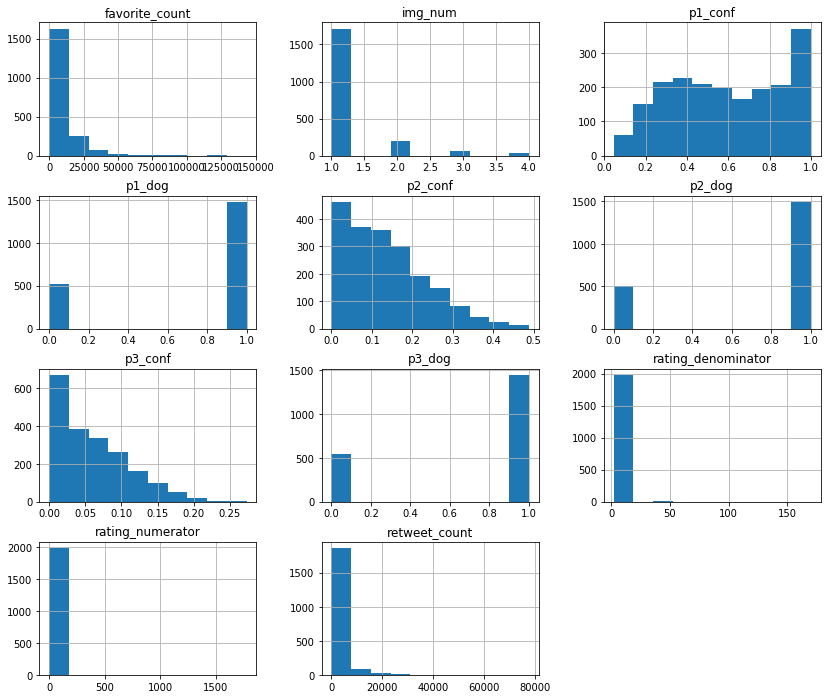

In [80]:
# Create histogram of "full_data"
full_data.hist(figsize=(14,12));

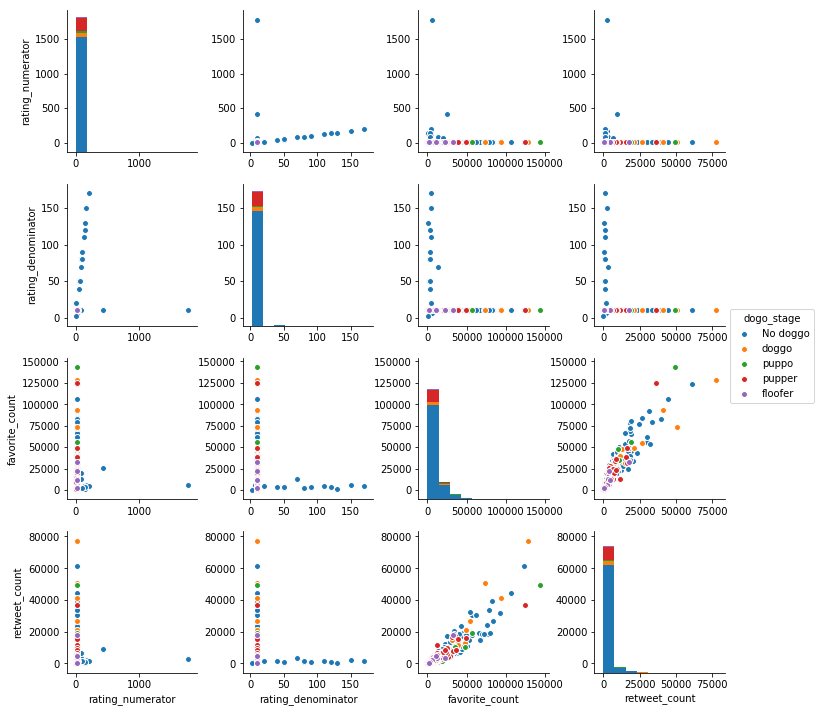

In [81]:
# Pair plot of the ratings, favorite count and retweet counts colored by "dogo_stage"
sns.pairplot(full_data[['dogo_stage','rating_numerator','rating_denominator','favorite_count','retweet_count']],\
             hue="dogo_stage");

We can see that in the case of favorite and retweet there is a correlation.

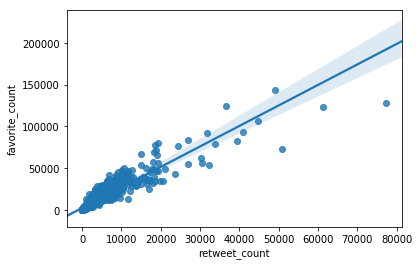

In [82]:
# Create a plot with a linear regression between "retweet_count" and "favorite_count"
sns.regplot(data=full_data, x="retweet_count", y="favorite_count");

If we want to check the percentage of dogo's types on the rows we have dogo we have:

In [83]:
# Count of tweets with each doggo category
full_data.dogo_stage.value_counts()

No doggo    1699
pupper       203
doggo         63
puppo         22
floofer        7
Name: dogo_stage, dtype: int64

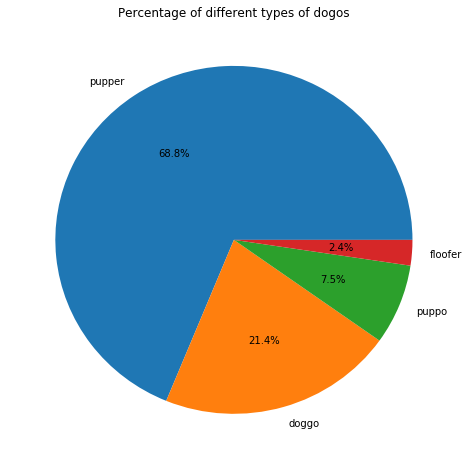

In [84]:
# Create a pie plot with the different percentages of dogos
full_data.query('dogo_stage != "No doggo"').dogo_stage.value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8));
plt.title('Percentage of different types of dogos')
plt.ylabel('')
plt.show()

In the next plot I will create a bar plot with the top 10 most favorites breeds of dogs that are predicted with a confidence greater than or equal to 95%. To do that I did it using a SQL query and querying the data in the database that I created before.

In [85]:
#Table with the breeds of dogs with more favorites
favorite_breeds = pd.read_sql('''SELECT p1 AS breed, SUM(favorite_count) AS total_sum_favorites 
                                 FROM twitter_data 
                                 WHERE p1_conf >= 0.95 AND p1 != "Not a dog"
                                 GROUP BY p1 
                                 ORDER BY total_sum_favorites DESC
                                 LIMIT 10''', conn)

#Show the top 10 most favorites breeds
favorite_breeds

,breed,total_sum_favorites
0,Pembroke,313152
1,Samoyed,246169
2,golden_retriever,149438
3,Labrador_retriever,137622
4,pug,119400
5,French_bulldog,116557
6,Pomeranian,96036
7,chow,65927
8,Shetland_sheepdog,57867
9,Chihuahua,44666


To create the next plot I found some help on how to change the size of a Seaborn barplot on this [page](https://kite.com/python/answers/how-to-change-the-seaborn-plot-figure-size-in-python).

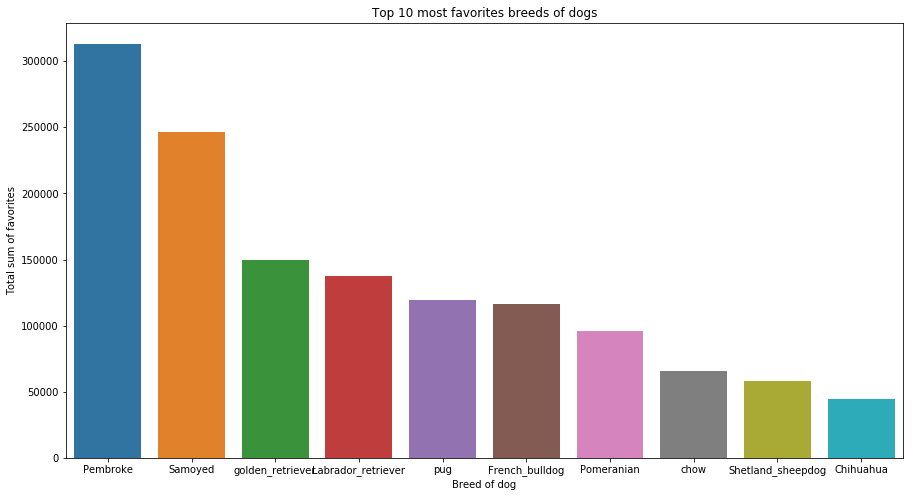

In [86]:
# Configure the dimensions of the plot
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)

# Plot in a barplot the top 10 most favorites breeds of dogs
sns.barplot(data = favorite_breeds, x = 'breed', y = 'total_sum_favorites', ax=ax);
plt.xlabel('Breed of dog');
plt.ylabel('Total sum of favorites');
plt.title('Top 10 most favorites breeds of dogs');
plt.show()

In [89]:
# Create HTML file
from subprocess import call
call(['python', '-m', 'nbconvert', 'wrangle_act.ipynb'])

0